<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/Human_Activity_Recognition_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import callbacks
#callbacks.ModelCheckPoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [85]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

File ‘UCI-HAR.zip’ already there; not retrieving.



In [86]:
!unzip -nq UCI-HAR.zip

In [87]:
!ls

 best_model_basic   __MACOSX    sample_data	   UCI-HAR.zip
 best_model.h5	    model.png  'UCI HAR Dataset'


In [88]:
!ls 'UCI HAR Dataset'

activity_labels.txt  features_info.txt	features.txt  README.txt  test	train


In [89]:
!ls 'UCI HAR Dataset/train'

'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt


In [ ]:
!head 'UCI HAR Dataset/train/X_train.txt'

In [91]:
!head 'UCI HAR Dataset/train/y_train.txt'

5
5
5
5
5
5
5
5
5
5


In [92]:
!ls 'UCI HAR Dataset/train/Inertial Signals'

body_acc_x_train.txt  body_gyro_x_train.txt  total_acc_x_train.txt
body_acc_y_train.txt  body_gyro_y_train.txt  total_acc_y_train.txt
body_acc_z_train.txt  body_gyro_z_train.txt  total_acc_z_train.txt


In [93]:
!ls 'UCI HAR Dataset/test/Inertial Signals'

body_acc_x_test.txt  body_gyro_x_test.txt  total_acc_x_test.txt
body_acc_y_test.txt  body_gyro_y_test.txt  total_acc_y_test.txt
body_acc_z_test.txt  body_gyro_z_test.txt  total_acc_z_test.txt


In [ ]:
!head 'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt'

In [95]:
#Since the data is separated by a white space - delim_whitespace = True
#Since this dataset dont have header - header = None
df = pd.read_csv(
    'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt',
    header = None,
    delim_whitespace = True
)

In [96]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 128 entries, 0 to 127
dtypes: float64(128)
memory usage: 7.2 MB


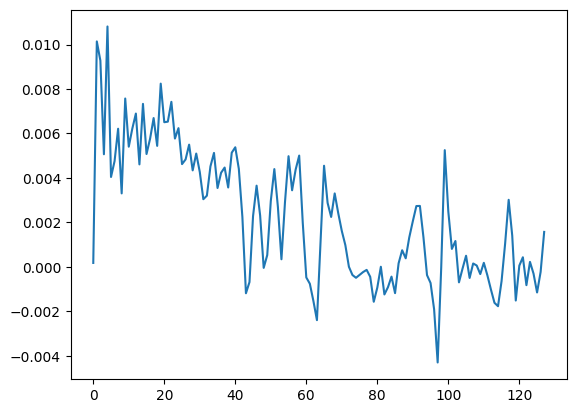

In [98]:
df.iloc[0].plot();

In [99]:
#Obtain these by inspecting the files
T = 128
NTrain = 7352
NTest = 2947
D = 9 #Since there are 9 files
K = 6 #number of classes (1-6)

In [100]:
def load_data():
  XTrain = np.zeros((NTrain,T,D))
  XTest = np.zeros((NTest,T,D))

  #Train Data
  ts_filenames = [
    'body_acc_x_train.txt',  'body_gyro_x_train.txt',  'total_acc_x_train.txt',
    'body_acc_y_train.txt',  'body_gyro_y_train.txt',  'total_acc_y_train.txt',
    'body_acc_z_train.txt',  'body_gyro_z_train.txt',  'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d,fn in enumerate(ts_filenames):
    df = pd.read_csv(
    f'{ts_file_prefix}Inertial Signals/{fn}',
    header = None,
    delim_whitespace = True
  )

    #NTrain x T array
    x = df.to_numpy()
    XTrain[:,:,d] = x

  YTrain = pd.read_csv(
    f'{ts_file_prefix}y_train.txt',header = None).to_numpy() - 1
  YTrain = YTrain.flatten()

  #Test Data
  ts_filenames = [
      'body_acc_x_test.txt',  'body_gyro_x_test.txt',  'total_acc_x_test.txt',
      'body_acc_y_test.txt',  'body_gyro_y_test.txt',  'total_acc_y_test.txt',
      'body_acc_z_test.txt',  'body_gyro_z_test.txt',  'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d,fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header = None,
        delim_whitespace = True
    )

    #NTrain x T array
    x = df.to_numpy()
    XTest[:,:,d] = x

  # test labels
  YTest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt',header = None
  ).to_numpy() - 1

  YTest = YTest.flatten()

  return XTrain,YTrain,XTest,YTest


In [101]:
XTrain,YTrain,XTest,YTest = load_data()

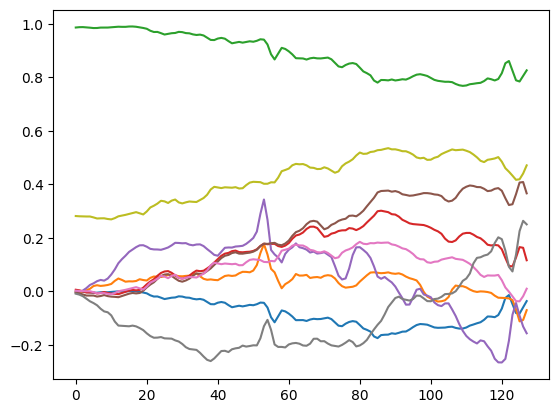

In [102]:
 #Plot all d = 9 time series of length T = 128
plt.plot(XTrain[7000, :, :]);

In [103]:
#ANN
inputs = []
features = []

#Make a neural network for each of the D time series
for d in range(D):
  i = Input(shape=(T,))
  x = Dense(32,activation='relu')(i)
  x = Dense(16,activation='relu')(x)
  inputs.append(i)
  features.append(x)

#Output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features)
x = Dense(K)(x)
model = Model(inputs,x)

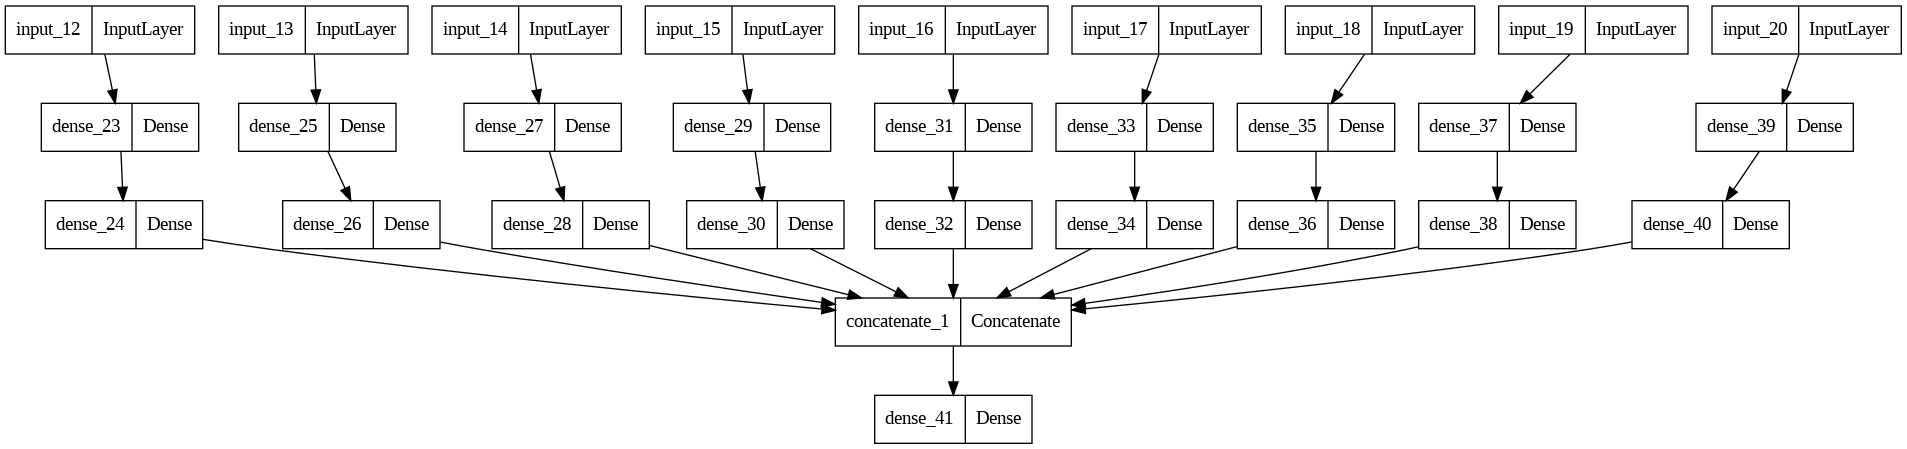

In [104]:
tf.keras.utils.plot_model(model)

In [105]:
from keras.callbacks import ModelCheckpoint
check_point = ModelCheckpoint(
    'best_model.h5',monitor = 'val_accuracy',save_best_only = True
)

In [106]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [107]:
XTrain_split = []
XTest_split = []
for d in range(D):
  XTrain_split.append(XTrain[:,:,d])
  XTest_split.append(XTest[:,:,d])

In [108]:
r = model.fit(
    XTrain_split,
    YTrain,
    epochs = 15,
    callbacks = [check_point],
    validation_data = (XTest_split,YTest)
)

Epoch 1/15
230/230 [==============================] - 6s 13ms/step - loss: 0.6398 - accuracy: 0.7831 - val_loss: 0.4594 - val_accuracy: 0.8446
Epoch 2/15
  7/230 [..............................] - ETA: 1s - loss: 0.2815 - accuracy: 0.9152

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 2s 10ms/step - loss: 0.2279 - accuracy: 0.9218 - val_loss: 0.3598 - val_accuracy: 0.8683
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1649 - accuracy: 0.9421 - val_loss: 0.3384 - val_accuracy: 0.8782
Epoch 4/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1362 - accuracy: 0.9504 - val_loss: 0.3327 - val_accuracy: 0.8955
Epoch 5/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1207 - accuracy: 0.9584 - val_loss: 0.2962 - val_accuracy: 0.8985
Epoch 6/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1078 - accuracy: 0.9610 - val_loss: 0.3080 - val_accuracy: 0.8918
Epoch 7/15
230/230 [==============================] - 1s 6ms/step - loss: 0.1005 - accuracy: 0.9638 - val_loss: 0.3130 - val_accuracy: 0.8958
Epoch 8/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0962 - accuracy: 0.9656 - val_loss: 0.2790 - val_accuracy: 0.9046
Epoch 9/15
230/2

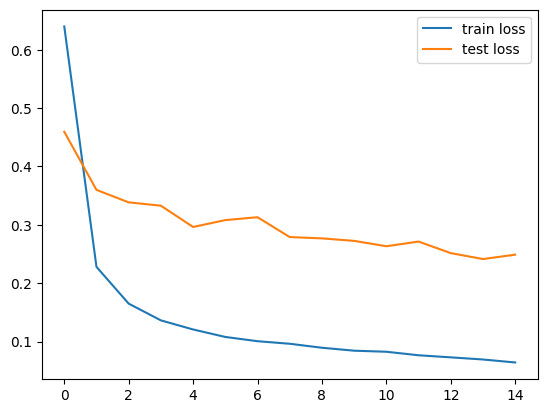

In [109]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend()

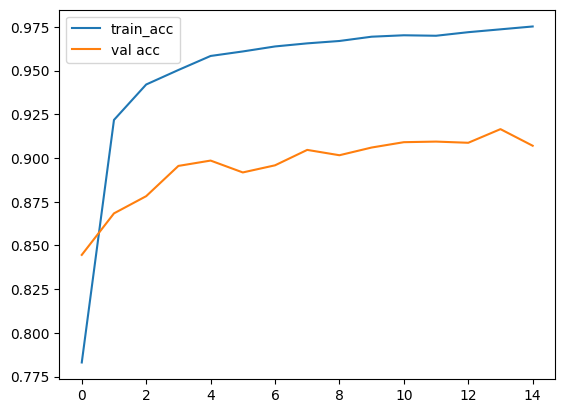

In [110]:
plt.plot(r.history['accuracy'],label = 'train_acc')
plt.plot(r.history['val_accuracy'],label = 'val acc')
plt.legend();

In [111]:
#Load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [112]:
#Make predictions
PTest = best_model.predict(XTest_split)

93/93 [==============================] - 1s 8ms/step


In [113]:
#True ANS = 1,Wrong ANS = 0
#Get the mean to calculate accuracy
np.mean(np.argmax(PTest,axis = 1) == YTest)

0.9165252799457075

In [114]:
from sklearn.preprocessing import StandardScaler

def load_features():
  #Train Data
  df = pd.read_csv(
      'UCI HAR Dataset/train/X_train.txt',
      header = None,
      delim_whitespace = True
  )

  feat_train = df.to_numpy()

  #Test Data
  df = pd.read_csv(
      'UCI HAR Dataset/test/X_test.txt',
      header = None,
      delim_whitespace = True
  )

  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train= scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train,feat_test

In [115]:
feat_train,feat_test = load_features()

In [116]:
#Get the number of columns
D_feat = feat_train.shape[1]
D_feat

561

In [117]:
#Basic ANN
i = Input(shape=(D_feat,))
x = Dense(32,activation = 'relu')(i)
x = Dense(K)(x)
model = Model(i,x)

In [118]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [119]:
check_point2 = ModelCheckpoint(
    'best_model_basic',monitor = 'val_accuracy',save_best_model = True
)

In [120]:
r = model.fit(
    feat_train,
    YTrain,
    epochs = 15,
    callbacks = [check_point2],
    validation_data = (feat_test,YTest)
)

Epoch 1/15
230/230 [==============================] - 3s 10ms/step - loss: 0.3309 - accuracy: 0.8726 - val_loss: 0.1863 - val_accuracy: 0.9376
Epoch 2/15
230/230 [==============================] - 2s 8ms/step - loss: 0.1065 - accuracy: 0.9634 - val_loss: 0.1499 - val_accuracy: 0.9471
Epoch 3/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0763 - accuracy: 0.9743 - val_loss: 0.1515 - val_accuracy: 0.9427
Epoch 4/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0597 - accuracy: 0.9780 - val_loss: 0.1451 - val_accuracy: 0.9484
Epoch 5/15
230/230 [==============================] - 2s 10ms/step - loss: 0.0517 - accuracy: 0.9827 - val_loss: 0.1423 - val_accuracy: 0.9488
Epoch 6/15
230/230 [==============================] - 5s 20ms/step - loss: 0.0442 - accuracy: 0.9845 - val_loss: 0.1393 - val_accuracy: 0.9518
Epoch 7/15
230/230 [==============================] - 4s 19ms/step - loss: 0.0444 - accuracy: 0.9844 - val_loss: 0.1563 - val_accuracy: 0.9457
Ep

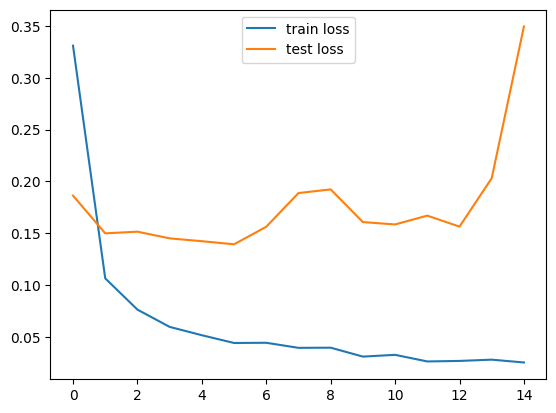

In [121]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

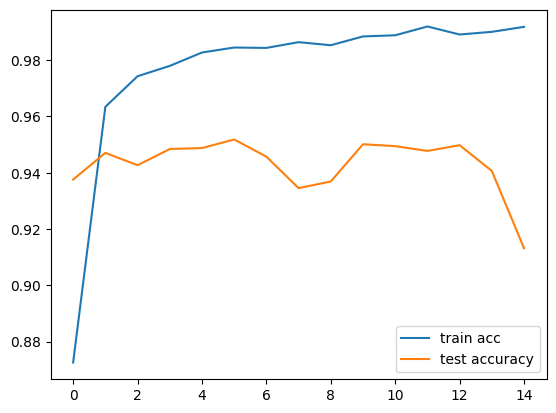

In [122]:
plt.plot(r.history['accuracy'],label = 'train acc')
plt.plot(r.history['val_accuracy'],label = 'test accuracy')
plt.legend();

In [123]:
#Load best model
best_model = tf.keras.models.load_model('best_model_basic')

In [124]:
#Make predictions
PTest = best_model.predict(feat_test)

93/93 [==============================] - 1s 7ms/step


In [125]:
#Evaluate
np.mean(np.argmax(PTest,axis = 1) == YTest)

0.9131319986426875

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [127]:
model = LogisticRegression(
    solver = 'liblinear'
)
model.fit(feat_train,YTrain)
model.score(feat_train,YTrain)

0.9945593035908596

In [128]:
model.score(feat_test,YTest)

0.9613165931455717

In [129]:
model = SVC()
model.fit(feat_train,YTrain)
model.score(feat_train,YTrain)

0.9866702937976061

In [130]:
model.score(feat_test,YTest)

0.9521547336274178

In [131]:
model = SVC(kernel = 'linear')
model.fit(feat_train,YTrain)
model.score(feat_train,YTrain)

0.9968715995647442

In [132]:
model.score(feat_test,YTest)

0.9609772650152698

In [133]:
model = RandomForestClassifier()
model.fit(feat_train,YTrain),
model.score(feat_train,YTrain)

1.0

In [134]:
#Random Forest performs well in the train set
#But perform badly in the test set
model.score(feat_test,YTest)

0.9307770614183916

In [146]:
#Combine model
inputs = []
features = []

#make a neural network for each of the D time series
for d in range(D):
  i = Input(shape = (T,))
  x = Dense(32,activation = 'relu')(i)
  x = Dense(16,activation = 'relu')(x)
  inputs.append(i)
  features.append(x)

i2 = Input(shape = (D_feat,))
x2 = Dense(32,activation = 'relu')(i2)

#Output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features + [x2])
x = Dense(K)(x)
model = Model(inputs + [i2],x)

In [147]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [148]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5',monitor = 'val_accuracy',true_best_model = True
)

In [149]:
r = model.fit(
    XTrain_split + [feat_train],
    YTrain,
    epochs = 15,
    callbacks = [check_point3],
    validation_data = (XTest_split + [feat_test],YTest)
)

Epoch 1/15
230/230 [==============================] - 7s 16ms/step - loss: 0.2944 - accuracy: 0.9013 - val_loss: 0.2004 - val_accuracy: 0.9267
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 2s 9ms/step - loss: 0.0912 - accuracy: 0.9695 - val_loss: 0.1662 - val_accuracy: 0.9427
Epoch 3/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0677 - accuracy: 0.9762 - val_loss: 0.1615 - val_accuracy: 0.9450
Epoch 4/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0566 - accuracy: 0.9789 - val_loss: 0.1737 - val_accuracy: 0.9427
Epoch 5/15
230/230 [==============================] - 3s 12ms/step - loss: 0.0504 - accuracy: 0.9819 - val_loss: 0.1424 - val_accuracy: 0.9494
Epoch 6/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0407 - accuracy: 0.9863 - val_loss: 0.1578 - val_accuracy: 0.9522
Epoch 7/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0405 - accuracy: 0.9856 - val_loss: 0.1704 - val_accuracy: 0.9488
Epoch 8/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.1855 - val_accuracy: 0.9444
Epoch 9/15
230

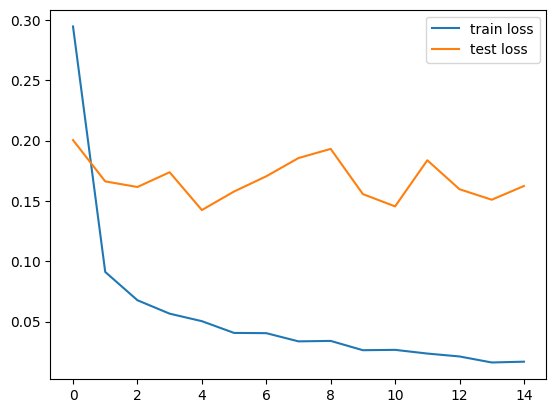

In [150]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

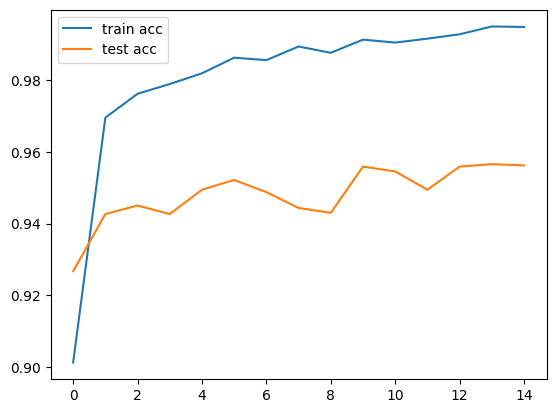

In [151]:
plt.plot(r.history['accuracy'],label = 'train acc')
plt.plot(r.history['val_accuracy'],label = 'test acc')
plt.legend();

In [155]:
#Load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [156]:
#Make Predictions
PTest = best_model.predict(XTest_split + [feat_test])

93/93 [==============================] - 1s 5ms/step


In [157]:
#Evaluate
np.mean(np.argmax(PTest,axis = 1) == YTest)

0.9562266711910418